In [1]:
import os

In [2]:
data_dir = './jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
data[:300]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30\n01'

In [5]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [6]:
print(header, '\n')
print('Total lines: ',len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"'] 

Total lines:  420551


In [7]:
print(lines[1:3]) # Information recorded every 10 min.

['01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10', '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']


In [8]:
# Converting all the lines into a big numpy array.
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1)) # Create an empty array as a placeholder.

In [9]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
float_data.shape

(420551, 14)

In [11]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in float_data[0:5,:]]))

996.52	-8.02	265.4	-8.9	93.3	3.33	3.11	0.22	1.94	3.12	1307.75	1.03	1.75	152.3
996.57	-8.41	265.01	-9.28	93.4	3.23	3.02	0.21	1.89	3.03	1309.8	0.72	1.5	136.1
996.53	-8.51	264.91	-9.31	93.9	3.21	3.01	0.2	1.88	3.02	1310.24	0.19	0.63	171.6
996.51	-8.31	265.12	-9.07	94.2	3.26	3.07	0.19	1.92	3.08	1309.19	0.34	0.5	198.0
996.51	-8.27	265.15	-9.04	94.1	3.27	3.08	0.19	1.92	3.09	1309.0	0.32	0.63	214.3


In [12]:
# Example of plotting the temperature.
from matplotlib import pyplot as plt
temp = float_data[:,1]
plt.figure(figsize = (14,8))
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 1400x800 with 1 Axes>

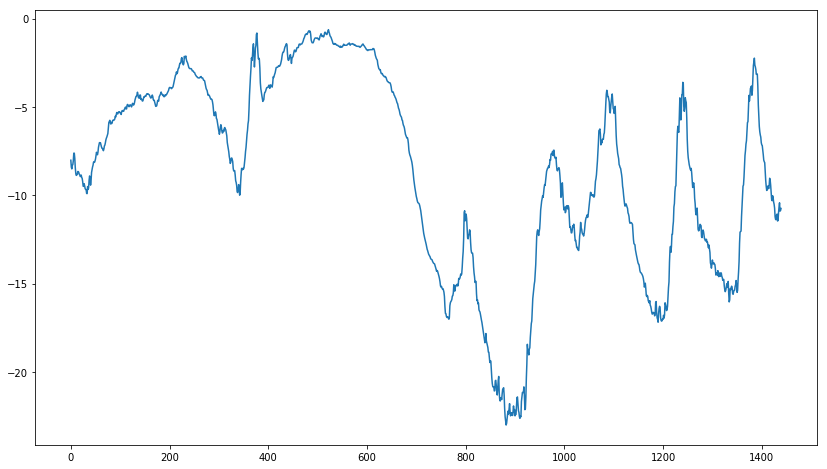

In [13]:
plt.figure(figsize = (14,8))
plt.plot(range(1440), temp[:1440])

In [14]:
# Given data goinf as far as LOOKBACK.
# With sampled points every STEPS minutes.
# Can we predict the temperature in DELAY timestamp.

lookback = 720 # We will go back 5 days.
steps = 6 # Data will be sample at one point per hour.
delays = 144 # Targets will be 24 hours in the future.

# We need to normalize & generate batches of data.
# We will use the first 200,000 steps as data for training.

In [15]:
# Normalizing the Data.....
mean = float_data.mean()
float_data += mean
std = float_data.std()
float_data /= std

In [16]:
float_data.shape[-1]

14

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    '''
    This function generate samples and targets of data for training a ML model.
    data = M x N nd.array where m is number os samples and n equal the number of features.
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback # Add the lookback to the min indice to never ga back more that min_index in dataset.
    
    while 1:
        if shuffle: # Ceckinf if data needs to be shuffle.
            # Generate rows indices.
            rows = np.random.randint(min_index + lookback, max_index, batch_size) # Generate a list of size batch_size of random number of indexes between min_index and max_index.
        else:
            if i + batch_size >= max_index: # If i + batch is greater that max_index reset i to begining of list.
                i = min_index + lookback # Reset i to begining of list.
            # Generate rows indices.        
            rows = np.arange(i, min(i + batch_size, max_index)) # return a list of indeces between i and min(i + batchsize and max_index).
            i += len(rows) # increment i based on the length of rows.
        
        # Create 2 nd.arrays to store the information.
        samples = np.zeros((len(rows), lookback // step, data.shape[-1])) # create a 3d array (# rows x int(lookback / step) x # features).
        targets = np.zeros((len(rows),)) # create a 1d array of targets.
        
        for j, row in enumerate(rows): # Iterate in each row
            indices = range(rows[j] - lookback, rows[j], step) # calculate the indices from row[j] - lookback steps to row[j], evert certain steps.
            samples[j] = data[indices] # save a list of samples based on indeces.
            targets[j] = data[rows[j] + delay][1] # save the target + delays from lookback.
        
        yield samples, targets # yield samples and targets.

In [35]:
# Testing the generator for the dataset.

lookback = 6 # We will go back n data sampled points or timestamps.
step = 2 # Data will be sample every the selected number of steps.
delay = 2 # Targets will be n sample points or timestamps in the future.
min_index = 0 # Start index for the dataset.
max_index = 100 # Maximun index for the dataset, help to control training and validation sets.
shuffle = False # If we want to shuffle data or not.
batch_size = 2 # the number of batches we want to create.

# Running rhe generator based on the specified parameter.
sample = generator(float_data,lookback, delay, min_index, max_index, shuffle, batch_size, step)

In [36]:
# Save one sample returned by the generator.
data_sample = next(sample)

In [37]:
# Print the shape of the sample data returned by the generator.
print('Sample data dimension: ', data_sample[0].shape)
print('.................')
print('Batch size = ', data_sample[0].shape[0])
print('Data points in the batch = ', data_sample[0].shape[1])
print('Features in the batch = ', data_sample[0].shape[2])


Sample data dimension:  (2, 3, 14)
.................
Batch size =  2
Data points in the batch =  3
Features in the batch =  14


In [38]:
data_sample

(array([[[3.14033762, 0.50409896, 1.22164169, 0.50178956, 0.76999549,
          0.53388504, 0.53330769, 0.52572339, 0.53023723, 0.53333393,
          3.95710605, 0.5278491 , 0.52973861, 0.92483062],
         [3.14036387, 0.50281304, 1.22035577, 0.50071358, 0.77157009,
          0.53357012, 0.53304526, 0.52567091, 0.53007977, 0.5330715 ,
          3.96364062, 0.52564466, 0.52679937, 0.97548008],
         [3.14031138, 0.50344288, 1.22098561, 0.50142215, 0.77209495,
          0.53372758, 0.53322896, 0.52564466, 0.53018474, 0.5332552 ,
          3.96038646, 0.52598583, 0.52679937, 1.08753872]],
 
        [[3.14046884, 0.50307547, 1.22061821, 0.50079231, 0.77025792,
          0.53362261, 0.5330715 , 0.52569715, 0.53010601, 0.53309774,
          3.96248592, 0.52703555, 0.52908253, 0.88231657],
         [3.14031138, 0.50333791, 1.22090688, 0.50134342, 0.77235738,
          0.53370134, 0.53320272, 0.52564466, 0.53018474, 0.53322896,
          3.96088508, 0.52603831, 0.5264582 , 1.04476224],
  

In [22]:
# Creating a 3 Generators.

# Generator parameters.
lookback = 1440 # We will go back n data sampled points or timestamps.
step = 6 # Data will be sample every the selected number of steps.
delay = 144 # Targets will be n sample points or timestamps in the future.
batch_size = 128 # the number of batches we want to create.

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000, shuffle = True,  step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,  step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,  step = step, batch_size = batch_size)

In [23]:
# How many steps I need to draw from this generator to see the entire validation set
val_steps = (300000 - 200001 - lookback)
# How many steps I need to draw from this generator to see the entire tesing set
test_steps  = (len(float_data) - 300001 - lookback)

In [24]:
# Simple Naive Method, temperature tomorrow is same as today. why not.
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # extracting the temperatures of the previous day as prediction.
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [25]:
type(evaluate_naive_method())

0.006730247043660968


NoneType

In [29]:
# A Simple Keras model using DNN Regressor.
# Importing the Keras Libraries.
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import RMSprop

In [34]:
# Building the model.
model = Sequential()
model.add(Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 250, epochs = 10, validation_data = val_gen, validation_steps = 100)

Epoch 1/10
250/250 [==============================] - 3s 12ms/step - loss: 0.2075 - val_loss: 0.0423
Epoch 2/10
250/250 [==============================] - 3s 11ms/step - loss: 0.0436 - val_loss: 0.0179
Epoch 3/10
250/250 [==============================] - 5s 22ms/step - loss: 0.0430 - val_loss: 0.0288
Epoch 4/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0428 - val_loss: 0.0515
Epoch 5/10
250/250 [==============================] - 3s 14ms/step - loss: 0.0421 - val_loss: 0.0422
Epoch 6/10
250/250 [==============================] - 3s 13ms/step - loss: 0.0417 - val_loss: 0.0232
Epoch 7/10
250/250 [==============================] - 3s 13ms/step - loss: 0.0414 - val_loss: 0.0381
Epoch 8/10
250/250 [==============================] - 3s 14ms/step - loss: 0.0411 - val_loss: 0.0534
Epoch 9/10
250/250 [==============================] - 3s 14ms/step - loss: 0.0405 - val_loss: 0.0260
Epoch 10/10
250/250 [==============================] - 3s 13ms/step - loss: 0.0399 - val_lo